In [1]:
import sys, os
sys.stderr = open(os.devnull, 'w')

import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json

from pendulum_ml.models.registry import make_model
from pendulum_ml.data.dataset import build_loaders
from pendulum_ml.verification.attacks import make_attack_fn
from pendulum_ml.verification import xai

run_clean = "quad_clean_config"
run_adv = "quad_adv_config"
base_path = Path("../experiments")
model_path= Path("../models/checkpoints")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def load_model(run_id):
    run_dir = base_path / run_id
    cfg = json.loads((run_dir / "config.json").read_text())
    model = make_model(cfg["model"]["name"],
                       in_dim=cfg["model"]["in_dim"],
                       hidden=tuple(cfg["model"]["hidden"]),
                       out_dim=cfg["model"]["out_dim"]).to(device)
    ckpt = model_path / f"{run_id}.pt"
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()
    return model, cfg

model_clean, cfg_clean = load_model(run_clean)
model_adv, cfg_adv = load_model(run_adv)
print(cfg_clean)


{'seed': 42, 'device': 'cpu', 'system': 'quadcopter', 'dynamics': {'dt': 0.01, 'control_dt': 0.01, 'integrator': 'rk4', 'params': {'quad': {'mass': 1.5, 'inertia': 0.03, 'arm_length': 0.25}, 'payload': {'mass': 0.25, 'rope_length': 1.0}, 'environment': {'gravity': 9.81}, 'winch': {'model': 'algebraic', 'omega': 10.0}, 'actuators': {'max_thrust': 20.0, 'max_pitch_torque': 5.0, 'min_pitch_torque': -5.0}}}, 'controller': {'type': 'pid', 'pid': {'x': {'Kp': 8, 'Ki': 0, 'Kd': 12, 'u_min': -10.0, 'u_max': 10.0}, 'z': {'Kp': 40.0, 'Ki': 5, 'Kd': 10, 'u_min': -10.0, 'u_max': 10.0, 'setpoint': 0.0}, 'theta': {'Kp': 30, 'Ki': 0, 'Kd': 4, 'u_min': -5.0, 'u_max': 5.0}, 'phi': {'Kp': 30.0, 'Ki': 0, 'Kd': 4.0, 'u_min': -10.0, 'u_max': 10.0}, 'l': {'Kp': 0.0, 'Ki': 0.0, 'Kd': 0.0, 'u_min': 0.0, 'u_max': 0.0}}}, 'data': {'n_trajectories': 1, 'initial_state': [[-0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]], 'sim_time': 20, 'train_ratio': 0.8, 'val_ratio': 0.1, 'test_ratio': 0.1, 'standardize': Tr

In [3]:
attack_fn = make_attack_fn(method="pgd", eps=0.1, steps=40, alpha=0.0025)
loaders = build_loaders(cfg_clean)
X_test, Y_test = next(iter(loaders["test"]))
X_test, Y_test = X_test.to(device), Y_test.to(device)

x = X_test[0:1]
y = Y_test[0:1]

x_adv = attack_fn(model_clean, x, y)

with torch.no_grad():
    clean_pred = model_clean(x)
    adv_pred = model_clean(x_adv)
    robust_pred = model_adv(x_adv)

print("Clean model (clean input):", clean_pred)
print("Clean model (adv input):", adv_pred)
print("Adv-trained model (adv input):", robust_pred)


Clean model (clean input): tensor([[-2.0983e-02,  1.6094e+00, -1.5982e-02,  2.8992e-02, -2.6324e-04]])
Clean model (adv input): tensor([[-0.1056,  1.8621, -0.0169,  0.1042,  0.0112]])
Adv-trained model (adv input): tensor([[ 0.0125,  1.6625, -0.0410,  0.0080,  0.0082]])


In [4]:
def evaluate(model, X, Y, attack_fn):
    with torch.no_grad():
        clean_loss = torch.nn.functional.mse_loss(model(X), Y).item()
    X_adv = attack_fn(model, X, Y)
    with torch.no_grad():
        adv_loss = torch.nn.functional.mse_loss(model(X_adv), Y).item()
    return clean_loss, adv_loss

epsilons = [0.01, 0.05, 0.08, 0.1, 0.2]
steps = [5, 10, 20, 40, 50]
results = []

for eps in epsilons:
    for s in steps:
        attack = make_attack_fn("pgd", eps=eps, steps=s, alpha=eps/s)
        loss_clean, loss_adv_clean = evaluate(model_clean, X_test, Y_test, attack)
        loss_clean_adv, loss_adv_adv = evaluate(model_adv, X_test, Y_test, attack)
        results.append((eps, s, loss_clean, loss_adv_clean, loss_clean_adv, loss_adv_adv))

import pandas as pd
df = pd.DataFrame(results, columns=["eps", "steps", "clean_loss", "adv_loss_clean", "clean_loss_adv","adv_loss_adv"])
df


,eps,steps,clean_loss,adv_loss_clean,clean_loss_adv,adv_loss_adv
0,0.01,5,0.003986,0.005097,0.002142,0.002657
1,0.01,10,0.003986,0.005258,0.002142,0.002794
2,0.01,20,0.003986,0.005169,0.002142,0.002642
3,0.01,40,0.003986,0.005258,0.002142,0.002784
4,0.01,50,0.003986,0.005214,0.002142,0.002661
5,0.05,5,0.003986,0.015391,0.002142,0.006806
6,0.05,10,0.003986,0.014726,0.002142,0.006058
7,0.05,20,0.003986,0.014330,0.002142,0.007466
8,0.05,40,0.003986,0.013602,0.002142,0.006337
9,0.05,50,0.003986,0.014955,0.002142,0.006955


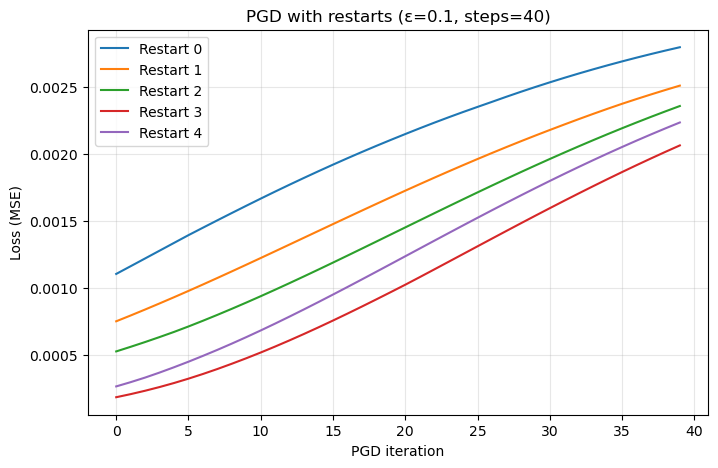

Best restart found final loss: 0.0028


In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# --- Helper functions ---
def _normalize_l2(v):
    flat = v.view(v.size(0), -1)
    norms = flat.norm(p=2, dim=1, keepdim=True).clamp_min(1e-12)
    return (flat / norms).view_as(v)

def _project_l2(delta, eps):
    flat = delta.view(delta.size(0), -1)
    norms = flat.norm(p=2, dim=1, keepdim=True)
    factors = (eps / norms).clamp_max(1.0)
    return (flat * factors).view_as(delta)

def pgd_trace(model, x, y, eps=0.1, steps=40, alpha=None, norm="l2", random_start=True):
    """PGD that records loss at every step for one input sample."""
    model.eval()
    mse = nn.MSELoss(reduction="mean")
    x0 = x.detach()
    y0 = y.detach()
    if alpha is None:
        alpha = eps / steps

    # initialize delta
    if random_start:
        delta = eps * _normalize_l2(torch.randn_like(x0))
    else:
        delta = torch.zeros_like(x0)

    trace = []
    for t in range(steps):
        delta.requires_grad_(True)
        x_adv = x0 + delta
        pred = model(x_adv)
        loss = mse(pred, y0)
        grad = torch.autograd.grad(loss, delta)[0]
        with torch.no_grad():
            delta = delta + alpha * _normalize_l2(grad)
            delta = _project_l2(delta, eps)
        trace.append(loss.item())
    x_adv = x0 + delta.detach()
    return x_adv, trace, delta.detach()

# --- Run experiment ---
idx = 0        # pick any test sample index
eps = 0.1
steps = 40
restarts = 5

x = X_test[idx:idx+1]
y = Y_test[idx:idx+1]

loss_traces = []
best_loss = -1
best_adv = None
best_delta = None

plt.figure(figsize=(8,5))
for r in range(restarts):
    x_adv, trace, delta = pgd_trace(model_clean, x, y, eps=eps, steps=steps)
    loss_traces.append(trace)
    plt.plot(trace, label=f"Restart {r}")
    if trace[-1] > best_loss:
        best_loss = trace[-1]
        best_adv = x_adv
        best_delta = delta
plt.xlabel("PGD iteration")
plt.ylabel("Loss (MSE)")
plt.title(f"PGD with restarts (ε={eps}, steps={steps})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Best restart found final loss: {best_loss:.4f}")


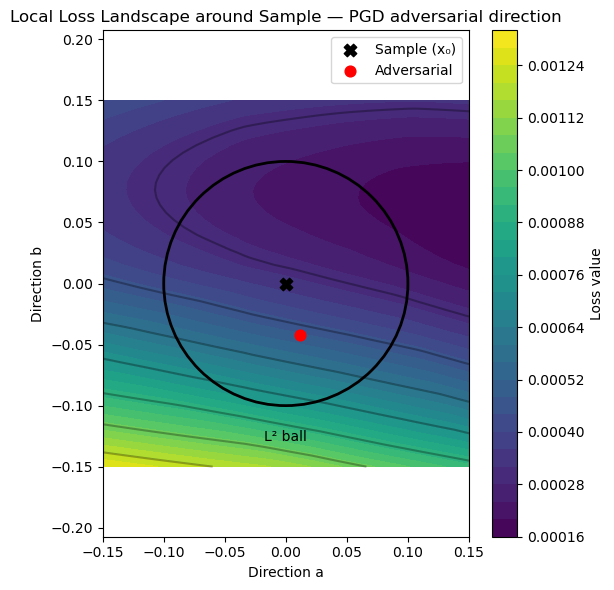

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- pick one test sample ---
idx = 0
x0 = X_test[idx:idx+1].clone().detach().to(device)
y0 = Y_test[idx:idx+1].clone().detach().to(device)

# --- make PGD attack to get adversarial example ---
attack = make_attack_fn("pgd", eps=0.2, steps=100, norm="l2")
x_adv = attack(model_clean, x0, y0)

# --- select 2 feature directions (axes for visualization) ---
# Option 1: random orthonormal directions
dim = x0.numel()
a = torch.randn(dim); b = torch.randn(dim)
# Gram-Schmidt to make them orthogonal
a = a / a.norm()
b = b - (a * (a @ b)).sum() * a
b = b / b.norm()

# Option 2: use specific feature indices (e.g., 0 and 1)
# a = torch.eye(dim)[0]; b = torch.eye(dim)[1]

# --- grid setup around x0 ---
r = 0.15  # radius for the grid
n = 50    # grid resolution
lin = torch.linspace(-r, r, n)
xx, yy = torch.meshgrid(lin, lin, indexing="xy")

loss_surface = torch.zeros_like(xx)
criterion = torch.nn.MSELoss(reduction="mean")

# --- evaluate loss surface ---
for i in range(n):
    for j in range(n):
        x_ij = x0 + xx[i, j] * a.view_as(x0) + yy[i, j] * b.view_as(x0)
        with torch.no_grad():
            pred = model_clean(x_ij)
            loss_surface[i, j] = criterion(pred, y0)

# --- compute center (clean) and adversarial positions in this 2D space ---
def project_to_plane(x):
    diff = (x - x0).view(-1)
    return float(diff @ a), float(diff @ b)

adv_ax, adv_ay = project_to_plane(x_adv)
circle_r = 0.1  # same as eps if using l2

# --- plot contour ---
plt.figure(figsize=(6,6))
cs = plt.contourf(xx, yy, loss_surface.cpu().numpy(), levels=30, cmap="viridis")
plt.colorbar(label="Loss value")
plt.contour(xx, yy, loss_surface.cpu().numpy(), levels=10, colors='k', alpha=0.3)

# Mark original and adversarial points
plt.scatter(0, 0, color="black", s=80, marker="X", label="Sample (x₀)")
plt.scatter(adv_ax, adv_ay, color="red", s=60, label="Adversarial")

# Draw L² ball boundary
circle = plt.Circle((0, 0), circle_r, color="black", fill=False, lw=2)
plt.gca().add_artist(circle)
plt.text(0, -circle_r-0.02, "L² ball", ha="center", va="top", fontsize=10)

plt.xlabel("Direction a")
plt.ylabel("Direction b")
plt.legend()
plt.title("Local Loss Landscape around Sample — PGD adversarial direction")
plt.axis("equal")
plt.tight_layout()
plt.show()


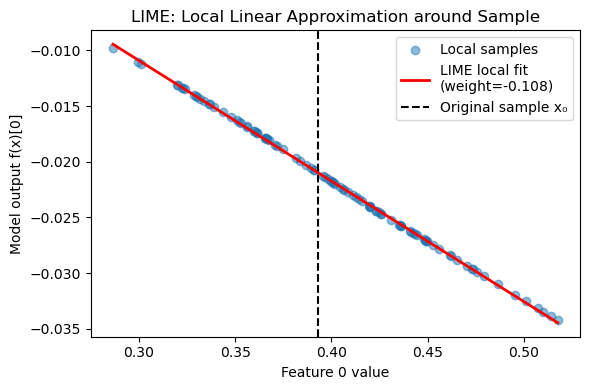

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Pick one sample and one output to explain
idx = 0
output_idx = 0  # choose which output dimension to visualize (0–4)
feat_idx = 0    # choose which feature to vary (0–14)

x0 = X_test[idx:idx+1].clone().detach().cpu().numpy().flatten()

# --- generate small local perturbations around x0 ---
num_samples = 100
X_local = np.tile(x0, (num_samples, 1))
X_local[:, feat_idx] += np.random.normal(0, 0.05, size=num_samples)  # perturb one feature

# --- get model predictions for those perturbed samples ---
with torch.no_grad():
    preds = model_clean(torch.tensor(X_local, dtype=torch.float32).to(device))
    preds = preds[:, output_idx].cpu().numpy().flatten()  # take specific output

# --- fit local linear model (1D linear regression) ---
A = np.vstack([X_local[:, feat_idx], np.ones(num_samples)]).T
coef, intercept = np.linalg.lstsq(A, preds, rcond=None)[0]

# --- line for visualization ---
line_x = np.linspace(X_local[:, feat_idx].min(), X_local[:, feat_idx].max(), 50)
line_y = coef * line_x + intercept

# --- plot ---
plt.figure(figsize=(6,4))
plt.scatter(X_local[:, feat_idx], preds, alpha=0.5, label="Local samples")
plt.plot(line_x, line_y, color="red", linewidth=2, label=f"LIME local fit\n(weight={coef:.3f})")
plt.axvline(x0[feat_idx], color="black", linestyle="--", label="Original sample x₀")
plt.xlabel(f"Feature {feat_idx} value")
plt.ylabel(f"Model output f(x)[{output_idx}]")
plt.title("LIME: Local Linear Approximation around Sample")
plt.legend()
plt.tight_layout()
plt.show()

